In [1]:
import json
import os
from pprint import pprint
import random

import cv2
import numpy as np
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Augmentation for SSD
1. Photometric Distortions
    - Random Brightness
    - Random Constrast
    - Random Hue
    - Random Saturation
    - Random Reorder Channels
1. Geometric Distortions
    - Random Hirozontal Filp
    - ExpandImage
    - RandomCrop
    - RandomMirror / Flip

In [28]:
#### Helper Functions
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b, color='yellow'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=1))
    #draw_outline(patch, 4)
    
## xmin, xmax, ymin, ymax
def bb_hw(bb): return np.array([bb[0], bb[2], bb[1]-bb[0]+1, bb[3]-bb[2]+1])
                            #   xmin   ymin   xmax-xmin+1    ymax-ymin+1
                     # top-left ( x      y )     width          height

def draw_im(im, ann):
    ax = show_img(im, figsize=(5,7))
    for b in ann:
        b = bb_hw(b)
        draw_rect(ax, b, color='yellow')

def get_bboxes(data_point):
    bboxes = []
    for bbox in data_point['annotations']:
        bboxes.append([bbox['xmin'], bbox['xmax'], bbox['ymin'], bbox['ymax']])
    return bboxes

In [21]:
# load test data
data_path = '../dataset/cone/'
labels_path = os.path.join(data_path, 'Labels')
images_path = os.path.join(data_path, 'Images')

with open(os.path.join(labels_path, 'test.json')) as f:
    ds = json.load(f)
data_point = ds[3]
img_path = os.path.join(images_path, data_point['filename'])

image = cv2.imread(img_path)
gt_bboxes = np.array(get_bboxes(data_point))
print(image.shape)
pprint(gt_bboxes)

(160, 160, 3)
array([[ 31,  63,   1,  29],
       [ 54, 109,   1,  44],
       [  7,  31,   1,  24]])


## Photometric Distortions

### Random Brightness

In [25]:
def brightness(image, delta):
    data = image.astype(np.float32)
    delta = random.randint(-delta, delta)
    data += delta
    data[data > 255] = 255
    data[data < 0] = 0
    data = data.astype(np.uint8)
    return data

def random_brightness(image, delta=0, prob=1):
    p = random.uniform(0, 1)
    if p < prob:
        return brightness(image, delta)
    return image

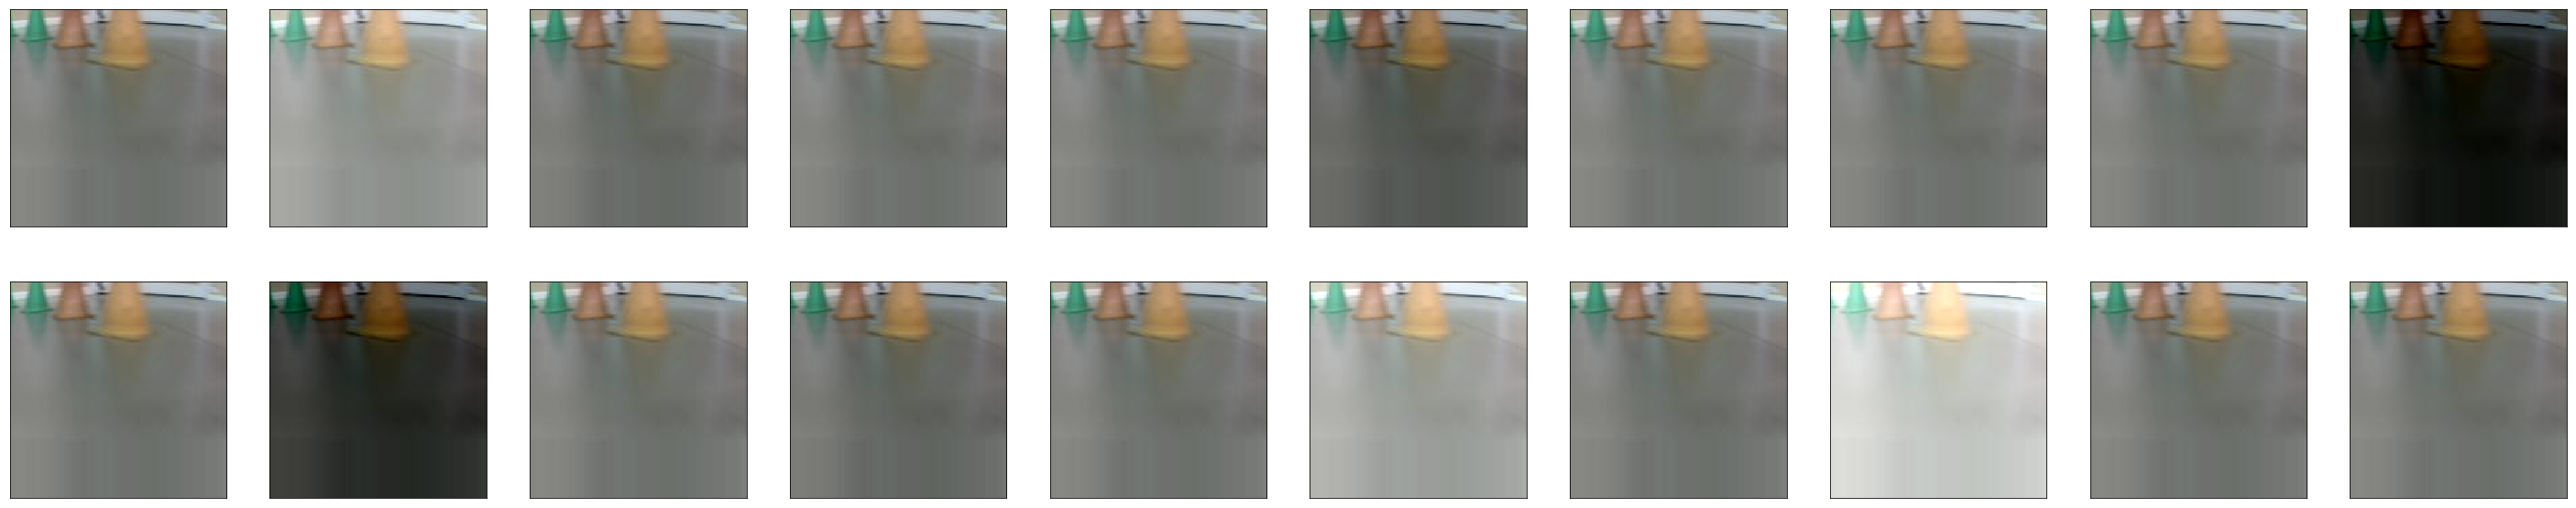

In [26]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))
for i, ax in enumerate(axes.flat):
    tf_image = random_brightness(image, delta=100, prob=0.5)
    show_img(tf_image, ax=ax)
plt.show()

### Random Constrast
- [read more about constrast](https://en.wikipedia.org/wiki/Contrast_(vision))

In [27]:
def constrast(image, lower, upper):
    data = image.astype(np.float32)
    delta = random.uniform(lower, upper)
    data *= delta
    data[data > 255] = 255
    data[data < 0] = 0
    data = data.astype(np.uint8)
    return data

def random_constrast(image, lower=0, upper=0, prob=1):
    p = random.uniform(0, 1)
    if p < prob:
        return constrast(image, lower, upper)
    return image


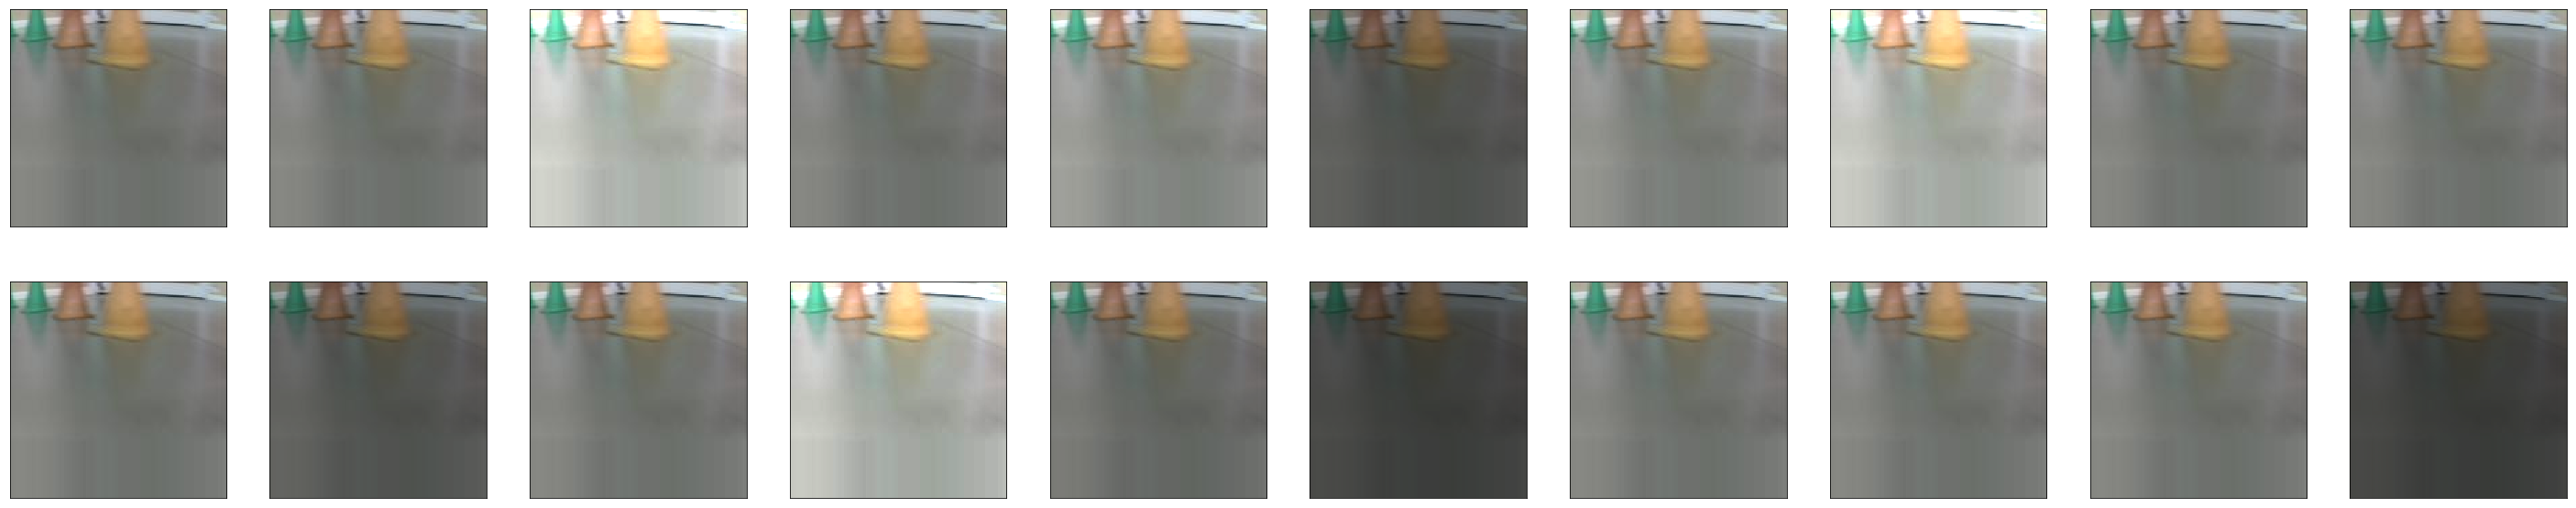

In [28]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))
for i, ax in enumerate(axes.flat):
    tf_image = random_constrast(image, lower=0.5, upper=1.8, prob=0.5)
    show_img(tf_image, ax=ax)
plt.show()

### Random Hue
- [Read about hue](https://en.wikipedia.org/wiki/Hue)

In [29]:
def hue(image, delta):
    data = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    data = data.astype(np.float32)
    delta = random.randint(-delta, delta)
    data[0] += delta
    data[0][data[0]>180] -= 180
    data[0][data[0]<0] +=180
    data = data.astype(np.uint8)
    data = cv2.cvtColor(data, cv2.COLOR_HSV2BGR)
    return data

def random_hue(image, delta=None, prob=1):
    p = random.uniform(0, 1)
    if p < prob:
        return hue(image, delta)
    return image

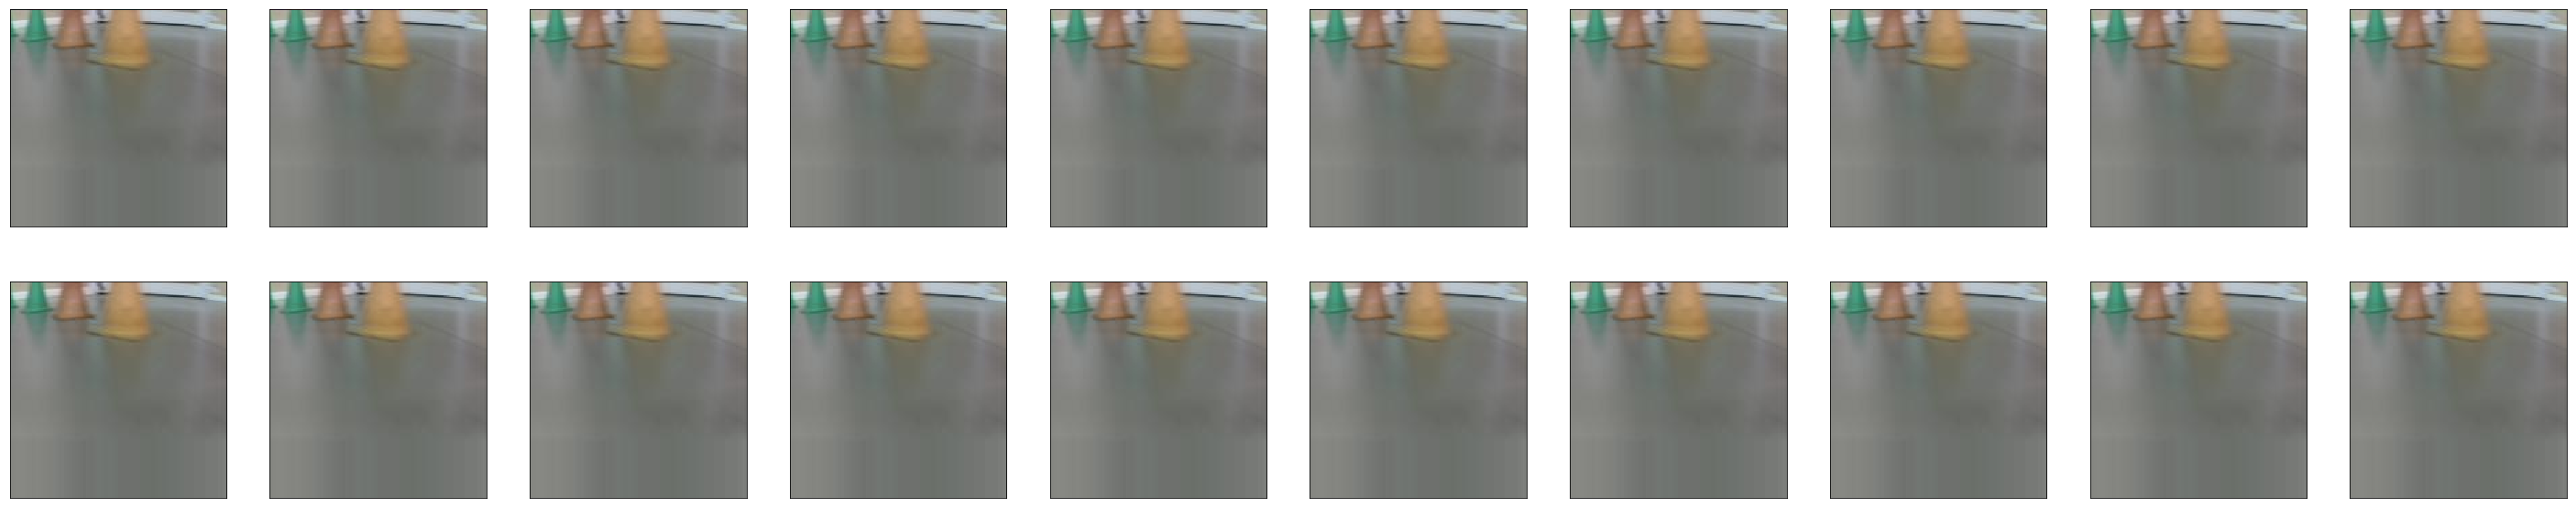

In [30]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))
for i, ax in enumerate(axes.flat):
    tf_image = random_hue(image, delta=100, prob=0.5)
    show_img(tf_image, ax=ax)
plt.show()

### Random Saturation
- [Read about saturation](https://en.wikipedia.org/wiki/Colorfulness)

In [31]:
def saturation(image, lower, upper):
    data = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    data = data.astype(np.float32)
    delta = random.uniform(lower, upper)
    data[1] *= delta
    data[1][data[1]>180] -= 180
    data[1][data[1]<0] +=180
    data = data.astype(np.uint8)
    data = cv2.cvtColor(data, cv2.COLOR_HSV2BGR)
    return data 

def random_saturation(image, lower=0, upper=0, prob=1):
    p = random.uniform(0, 1)
    if p < prob:
        return saturation(image, lower, upper)
    return image

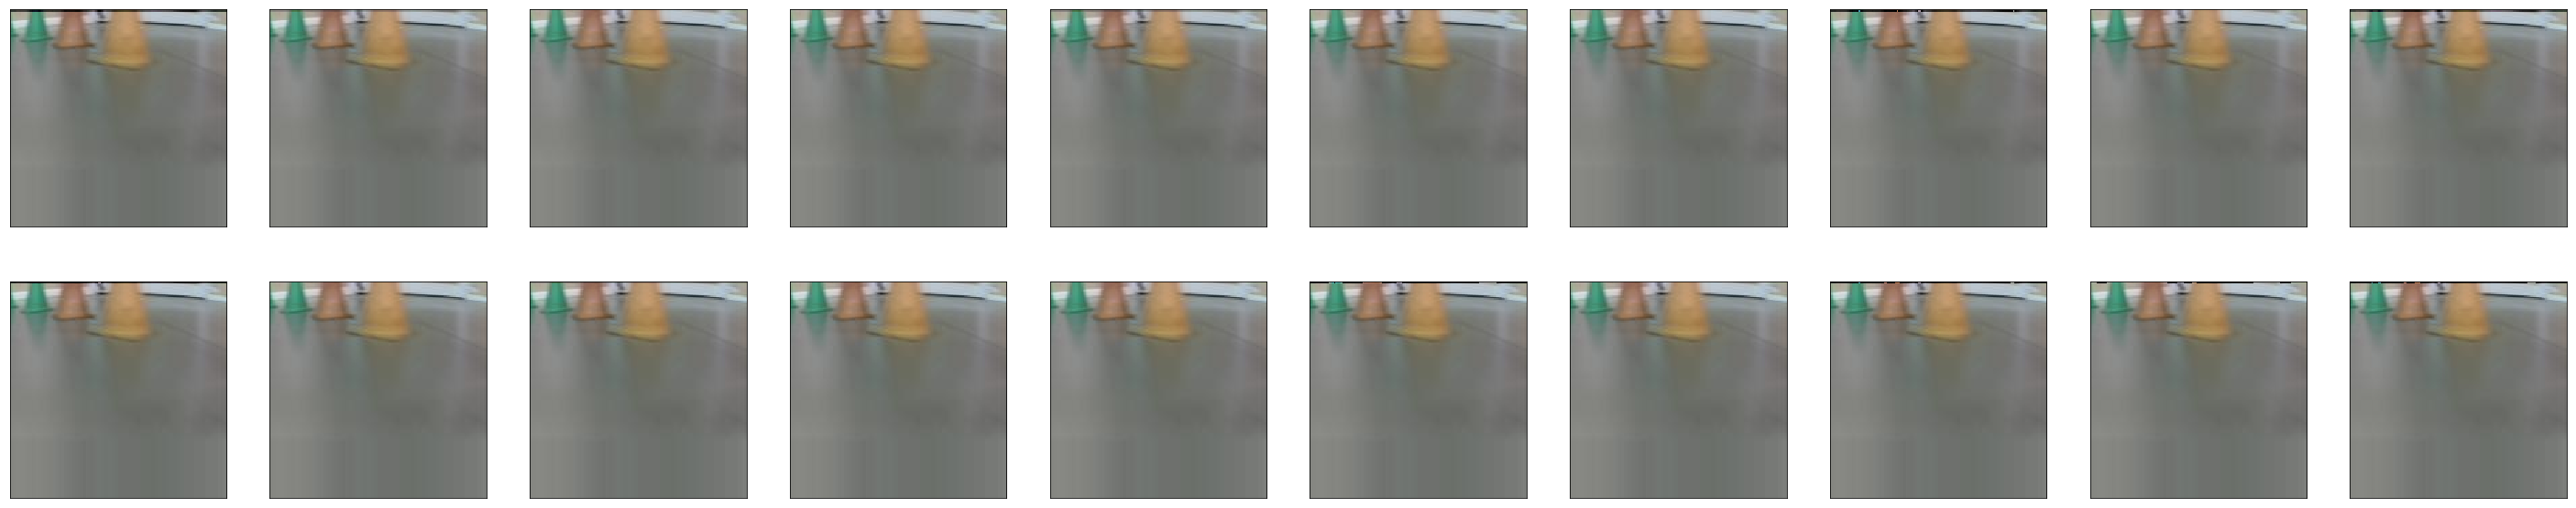

In [32]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))
for i, ax in enumerate(axes.flat):
    tf_image = random_saturation(image, lower=0.5, upper=1.5, prob=0.5)
    show_img(tf_image, ax=ax)
plt.show()

### Random Reorder Channels

In [33]:
def random_reorder_channels(image, prob=1):
    channels = [0, 1, 2]
    random.shuffle(channels)
    return image[:, :, channels]

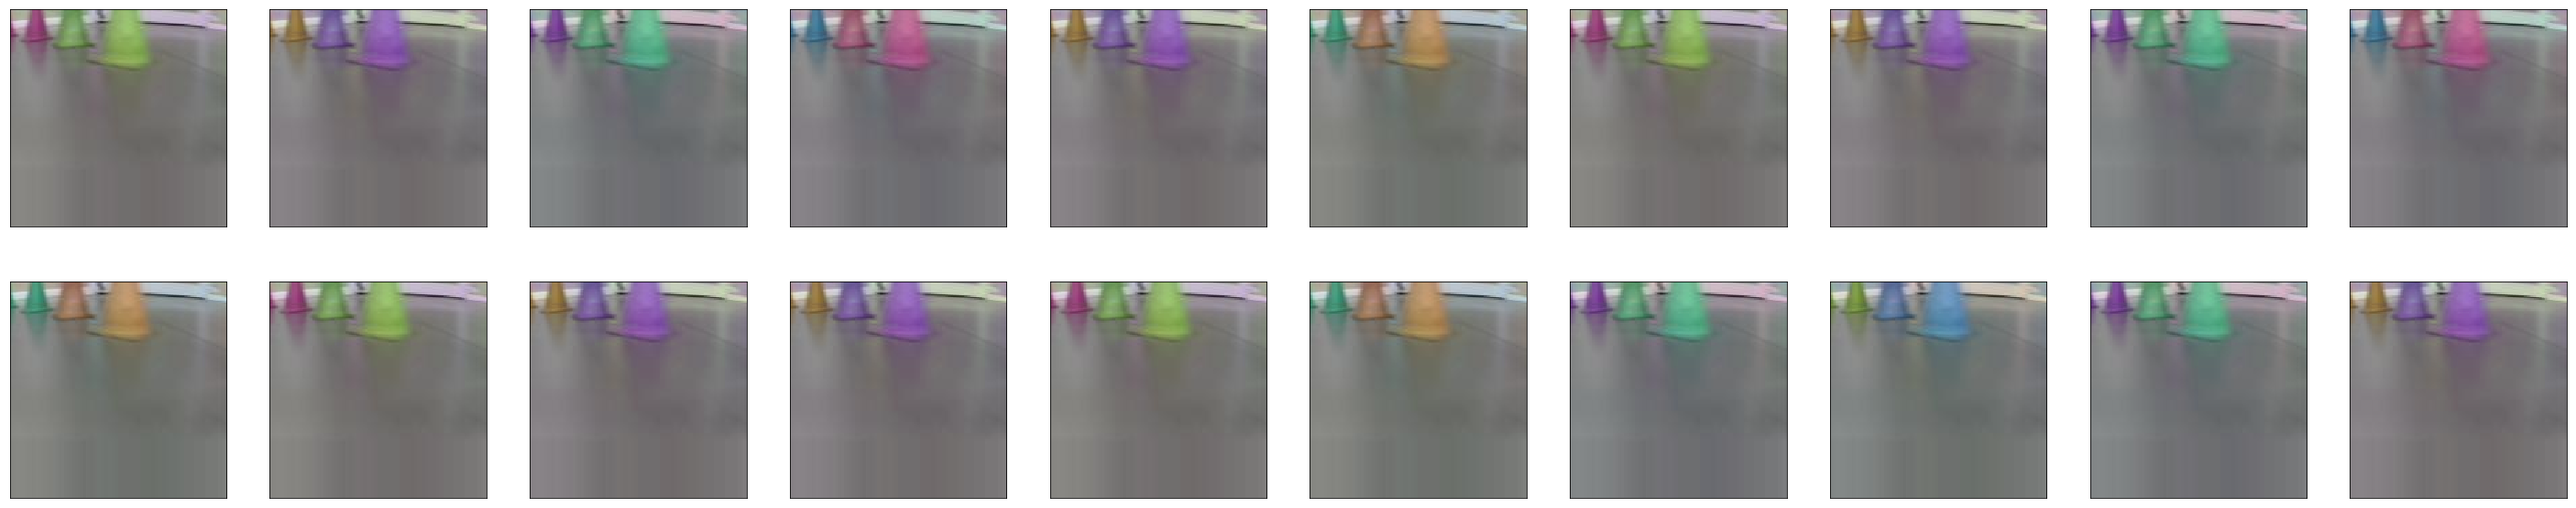

In [34]:
fig, axes = plt.subplots(2, 10, figsize=(50, 10))
for i, ax in enumerate(axes.flat):
    tf_image = random_reorder_channels(image, prob=0.5)
    show_img(tf_image, ax=ax)
plt.show()

## Geometric Distortions

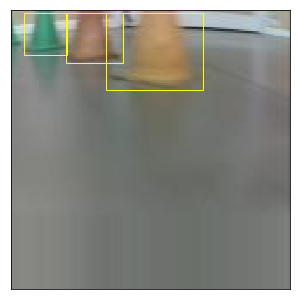

In [29]:
# plot the orginal image with bboxes
draw_im(image, gt_bboxes)

### Random Hirozontal Filp

In [33]:
def random_horizontal_filp(img, bboxes, p=1):
    img_center = np.array(img.shape[:2])[::-1]/2
    img_center = np.hstack((img_center, img_center)).astype(np.uint8)
    c_bboxes = np.copy(bboxes)
    if random.random() < p:
        img = img[:, ::-1, :]
        c_bboxes[:, [0, 1]] += 2*(img_center[[0, 1]] - bboxes[:, [0, 1]])
        
    return img, c_bboxes

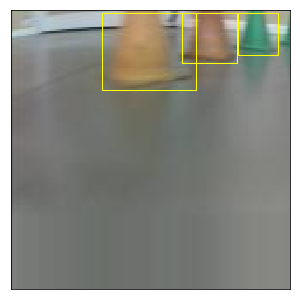

In [34]:
img, bboxes = random_horizontal_filp(image, gt_bboxes)
draw_im(img, bboxes)